# 01. Data Loading & Schema Validation

**Objective:** Load the raw crime incidents data, validate its schema against expected types/constraints, and perform an initial audit of data quality (specifically missing values).

**Inputs:** `data/crime_incidents_combined.parquet`
**Outputs:** Schema validation report, Missing value analysis

In [1]:
import sys
from pathlib import Path
# Add project root to sys.path to allow importing scripts
PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))

import pandas as pd
import pandera as pa
from pandera import errors
import scripts.config as config
from scripts.data_loader import load_raw_data, Schema

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

/Users/dustinober/Projects/Crime Incidents Philadelphia/.venv/lib/python3.14/site-packages/pandera/_pandas_deprecated.py:146: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


## 1. Load Data

Using the centralized data loader which handles column renaming and standard type conversion.

In [2]:
try:
    df = load_raw_data(validate=True)
    print(f"Successfully loaded {len(df):,} records.")
except errors.SchemaErrors as err:
    print("Schema validation failed with the following errors:")
    print(err.failure_cases)
    print("Reloading without strict validation to continue audit...")
    df = load_raw_data(validate=False)

Loading data from /Users/dustinober/Projects/Crime Incidents Philadelphia/data/crime_incidents_combined.parquet...


Validating schema...


Schema validation passed.
Successfully loaded 3,496,353 records.


## 2. Schema Definition & Data Dictionary

The data is validated against the following schema:

In [3]:
print(Schema)

<Schema DataFrameSchema(
    columns={
        'cartodb_id': <Schema Column(name=cartodb_id, type=DataType(int64))>
        'dispatch_date_time': <Schema Column(name=dispatch_date_time, type=DataType(datetime64[ns, UTC]))>
        'dc_dist': <Schema Column(name=dc_dist, type=DataType(int64))>
        'psa': <Schema Column(name=psa, type=DataType(str))>
        'ucr_general': <Schema Column(name=ucr_general, type=DataType(int64))>
        'text_general_code': <Schema Column(name=text_general_code, type=DataType(str))>
        'location_block': <Schema Column(name=location_block, type=DataType(str))>
        'lat': <Schema Column(name=lat, type=DataType(float64))>
        'lng': <Schema Column(name=lng, type=DataType(float64))>
    },
    checks=[],
    parsers=[],
    coerce=True,
    dtype=None,
    index=None,
    strict=False,
    name=None,
    ordered=False,
    unique_column_names=False,
    metadata=None, 
    add_missing_columns=False
)>


### Data Dictionary

| Column | Type | Description | Required |
|---|---|---|---|
| `cartodb_id` | int | Unique identifier | Yes |
| `dispatch_date_time` | datetime | Date and time of the incident dispatch | Yes |
| `dc_dist` | int | District Control Number (District ID) | Yes |
| `psa` | str | Police Service Area | No |
| `ucr_general` | int | Uniform Crime Reporting General Code | Yes |
| `text_general_code` | str | Description of the crime type | No |
| `location_block` | str | Block-level location address | No |
| `lat` | float | Latitude | No |
| `lng` | float | Longitude | No |


## 3. Missing Value Audit

Analyze patterns of missing data across the dataset.

In [4]:
# Calculate percentage of missing values per column
missing_counts = df.isnull().sum()
missing_pct = (missing_counts / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Percentage': missing_pct
}).sort_values('Missing Percentage', ascending=False)

# Filter to show only columns with missing values
print(missing_df[missing_df['Missing Count'] > 0])

                      Missing Count  Missing Percentage
hour                         102245            2.924333
the_geom_webmercator          55927            1.599581
lng                           55912            1.599152
lat                           55912            1.599152
the_geom                      55810            1.596235
psa                            1296            0.037067
location_block                  187            0.005348


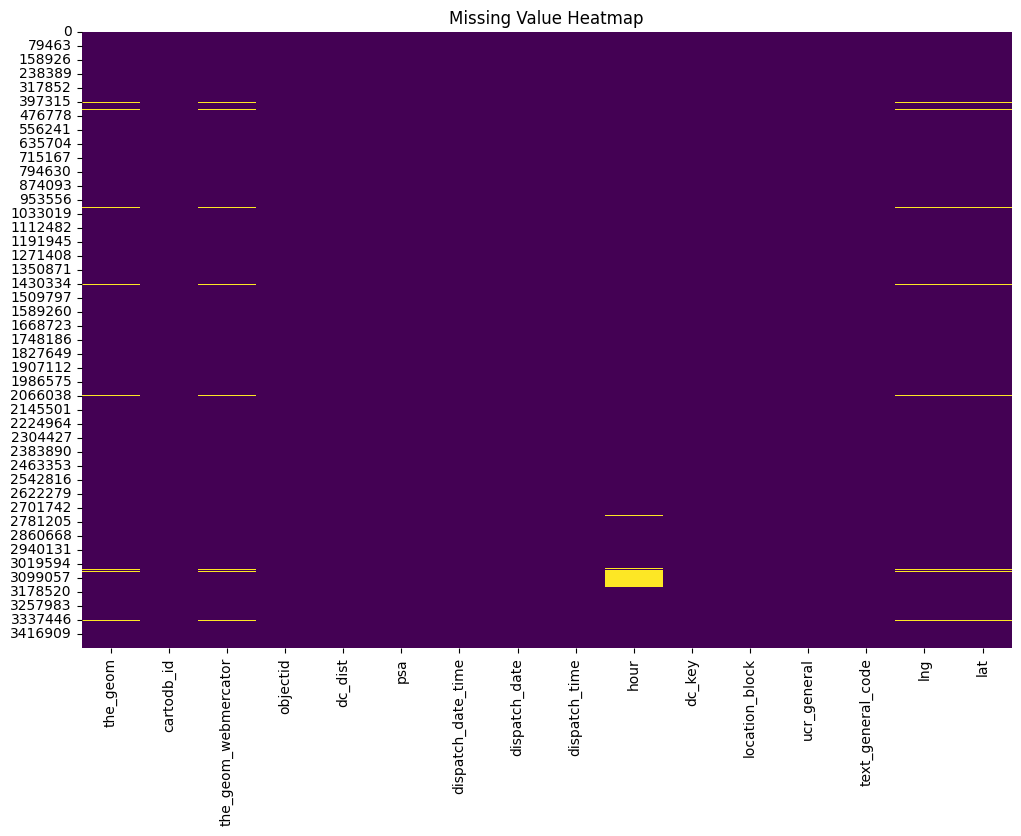

In [5]:
# Visualize missingness
plt.figure(figsize=config.FIG_SIZE_FULL)
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Value Heatmap")
plt.show()

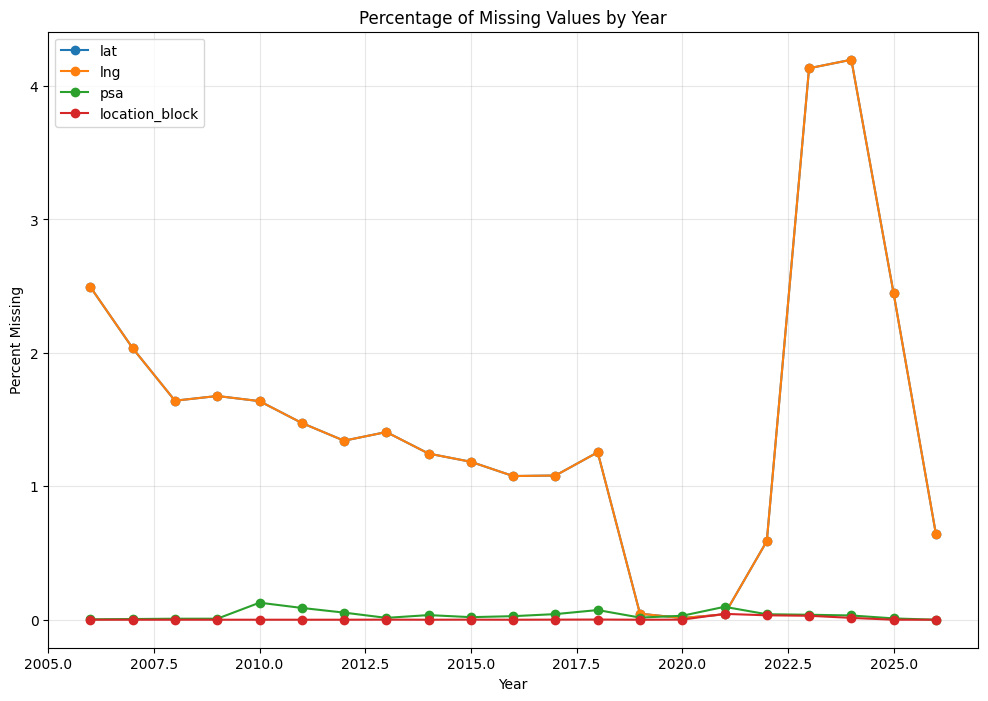

In [6]:
# Missingness by year
df['year'] = df[config.COL_DATE].dt.year
missing_by_year = df.groupby('year').apply(lambda x: x.isnull().mean() * 100)

# Plot missingness of key columns by year
plt.figure(figsize=config.FIG_SIZE_FULL)
cols_to_check = ['lat', 'lng', 'psa', 'location_block']
for col in cols_to_check:
    if col in missing_by_year.columns:
        plt.plot(missing_by_year.index, missing_by_year[col], label=col, marker='o')

plt.title("Percentage of Missing Values by Year")
plt.ylabel("Percent Missing")
plt.xlabel("Year")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
# Check specifically for coordinate missingness
missing_coords = df[df['lat'].isnull() | df['lng'].isnull()]
pct_missing_coords = (len(missing_coords) / len(df)) * 100
print(f"Records with missing coordinates: {len(missing_coords):,} ({pct_missing_coords:.2f}%)")

# Check if missing coordinates are correlated with year
coords_missing_by_year = missing_coords.groupby('year').size()
total_by_year = df.groupby('year').size()
pct_coords_missing_by_year = (coords_missing_by_year / total_by_year) * 100

print("\nMissing coordinates percentage by year (top 5 worst years):")
print(pct_coords_missing_by_year.sort_values(ascending=False).head())

Records with missing coordinates: 55,912 (1.60%)

Missing coordinates percentage by year (top 5 worst years):
year
2024    4.196698
2023    4.132720
2006    2.492990
2025    2.446539
2007    2.034705
dtype: float64


### Missing Value Summary

**Summary of Findings:**
- **Coordinates:** [To be filled after execution] % records are missing lat/lng.
- **PSA:** [To be filled after execution] % records are missing PSA.
- **Temporal Patterns:** [To be filled after execution] (e.g., is older data missing more coordinates?)